# ***Setup data directory***

In [1]:
# Setting up data directory
import os

base_dir = '/kaggle/input/tiny-imagenetstanford-cs231n/tiny-imagenet-200'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# ***Understanding the dataset*** 

In [2]:
# Check images 
from PIL import Image

example_class = os.listdir(os.path.join(train_dir))[0]
example_image = os.listdir(os.path.join(train_dir, example_class, "images"))[0]

img_path = os.path.join(train_dir, example_class, "images", example_image)
img = Image.open(img_path)

print("Image size:", img.size)  # (width, height)
print("Image mode:", img.mode)  # RGB or L

Image size: (64, 64)
Image mode: RGB


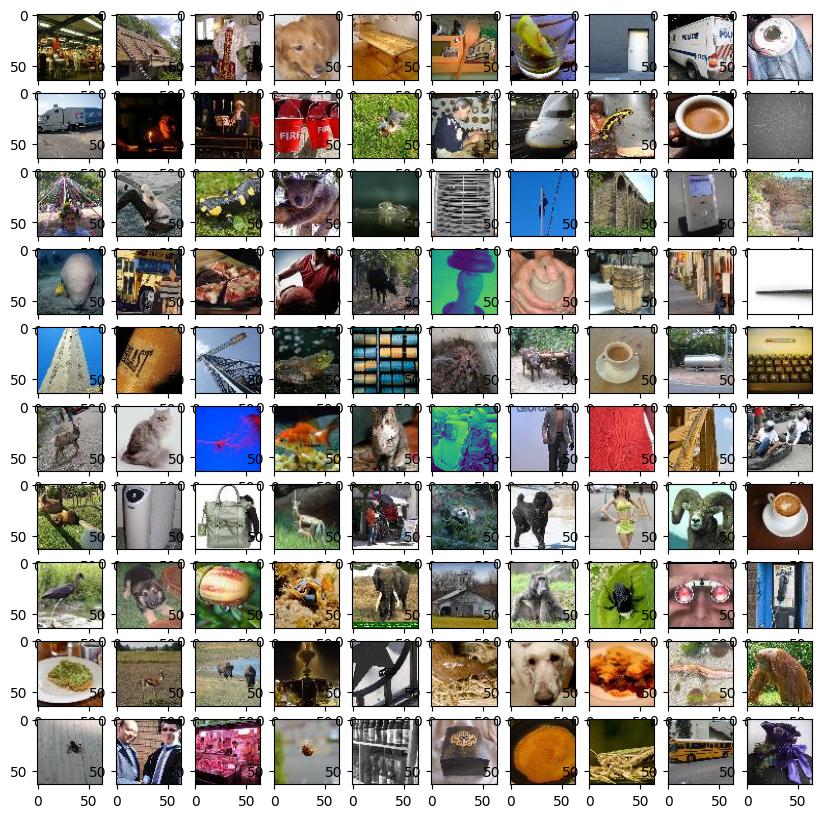

In [3]:
# Sample Random Images
import matplotlib.pyplot as plt
import os
import random 
import matplotlib.image as mpimg

def random_image_sampler(data_dir, row = 10, col = 10):
    fig, axes = plt.subplots(row, col, figsize = (10,10))
    
    image_list = os.listdir(data_dir) 
    random.shuffle(image_list)

    for i in range(row):
        for j in range(col):
            img_path = os.path.join(data_dir, image_list[i*col + j])
            img = mpimg.imread(img_path)
            axes[i,j].imshow(img)

random_image_sampler(os.path.join(val_dir, 'images'))

In [4]:
# Check different classes and check how many samples each one has
classes = os.listdir(train_dir)

sample_dist = {}
for cls in classes:
    count = len(os.listdir(os.path.join(train_dir, cls, 'images')))
    sample_dist[cls] = count
    if count != 500:
        print(f"Class {cls} contains {count} samples" )
    
#sample_dist

In [5]:
# Pixel value distribution
import numpy as np
def pixel_range(image):
    img_array = np.array(image)
    print("Pixel Values Range from ", img_array.min()," to ", img_array.max() )

pixel_range(img)

Pixel Values Range from  0  to  255


# ***Data Pipeline***

In [6]:
# Data Augmentation for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 128

# Training data
train_datagen = ImageDataGenerator(
    rescale = 1./255, # Nomalisez pixel values from [0,255] -> [0,1]
    rotation_range = 20, # Randomly rotates images by upto 20 degress
    width_shift_range = 0.2,# Shifts image horizontaly by upto 20% of width
    height_shift_range = 0.2,# Shifts image vertically by upto 20% of height 
    horizontal_flip = True, # Randomly flips images horizontaly (left<->right)
    zoom_range = 0.2,# Randonly zooms in/out images by upto 20%.
    fill_mode = 'nearest', # Fills in missing pixels after rotation and shifting 
)

#Validation data
val_datagen = ImageDataGenerator(rescale = 1./255) # Just rescale

2025-08-29 06:55:52.243221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756450552.421158      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756450552.472074      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Data resizing and preparation for training
img_size = (224,224) # 64x64 is the size in tiny imageNet, which needs to be upscaled to 224x224
# Training data
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 100000 images belonging to 200 classes.


In [8]:
# Since validation data is not segregated into folders, we will use 'val_annotations.txt' to create a dataframe which contains
# path information of the validation images
import os
import pandas as pd

# Read Annotation file
val_annot_path = os.path.join(base_dir,'val', 'val_annotations.txt')
val_annot_dataframe = pd.read_csv(val_annot_path, sep = '\t', header = None,
                                 names = ['file_name', 'class_name', 'x', 'y', 'w', 'h']) 

# Create new column called 'file_path'
val_annot_dataframe['file_path'] = val_annot_dataframe['file_name'].apply(
    lambda fname: os.path.join(base_dir,'val', 'images', fname))

# Now creating validation dataset using 'flow_from_directory'
val_dataset = val_datagen.flow_from_dataframe(
    dataframe = val_annot_dataframe,
    x_col = 'file_path',
    y_col = 'class_name',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)


Found 10000 validated image filenames belonging to 200 classes.


In [9]:
# AlexNet Architecture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape = (224,224,3), name = 'input_layer')

# 1st CNN set
conv1 = layers.Conv2D(
    filters = 96,
    kernel_size = (11,11),
    strides = (4,4), # Stride of 4 means ((224-11)/4 + 1) = 53 + 1 = 54. This is the reduction in dimentionality from input
    padding = 'valid',
    activation = 'relu',
    name = 'Conv1'
)(input_layer)

## Batch Normalization
bn1 = layers.BatchNormalization(name = 'bn1')(conv1)

## MaxPooling
pool1 = layers.MaxPooling2D(
    pool_size = (3,3),
    strides = (2,2), # Reduction in dimentionality -> ((55 - 3)/2 + 1) = 26
    padding = 'valid',
    name = 'pool1'
)(bn1)


# 2nd CNN set
conv2 = layers.Conv2D(
    filters = 256,
    kernel_size = (5,5),
    strides = (1,1), # Reduction in dimentionality -> 27/1 = 27
    padding = 'same',
    activation = 'relu',
    name = 'Conv2'    
)(pool1)

## Batch Normalization
bn2 = layers.BatchNormalization(name = 'bn2')(conv2)

##Max Pooling
pool2 = layers.MaxPooling2D(
    pool_size = (3,3),
    strides = (2,2), # Reduction in dimentionality -> ((27-3)/2 + 1) = 12
    padding = 'valid',
    name = 'pool2'
)(bn2)

# 3rd CNN set
conv3 = layers.Conv2D(
    filters = 384,
    kernel_size = (3,3),
    strides = (1,1),# Reduction in dimentionality -> 13/1  = 12
    activation = 'relu',
    padding = 'same',
    name = 'conv3'
)(pool2)

# 4th CNN set
conv4 = layers.Conv2D(
    filters = 384,
    kernel_size = (3,3),
    strides = (1,1),# Reduction in dimentionality -> 13/1  = 12
    activation = 'relu',
    padding = 'same',
    name = 'conv4'
)(conv3)

# 5th CNN set
conv5 = layers.Conv2D(
    filters = 256,
    kernel_size = (3,3),
    strides = (1,1),# Reduction in dimentionality -> 13/1  = 12
    activation = 'relu',
    padding = 'same',
    name = 'conv5'
)(conv4)

## Max Pooling
pool3 = layers.MaxPooling2D(
    pool_size = (3,3),
    strides = (2,2), # Reduction in dimentionality -> ((12-3/2) +1) = 5
    name = 'pool3'
)(conv5)

# Flatten the Pool output for fully connected layer
flat = layers.Flatten()(pool3)

# 1st Fully Connected layer
full1 = layers.Dense(1024, 'relu')(flat)
full1 = layers.Dropout(0.5)(full1)

# 2nd Fully Connected layer
full2 = layers.Dense(1024, 'relu')(full1)
full2 = layers.Dropout(0.5)(full2)

# Last Softmax layer
output_layer = layers.Dense(200, 'softmax')(full2)

# Model
AlexNet_tiny_ImageNet = keras.Model(input_layer, output_layer, name = 'AlexNet_tiny_ImageNet')


I0000 00:00:1756450644.152975      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
# Compile
AlexNet_tiny_ImageNet.compile(
    loss='categorical_crossentropy',   # or sparse_categorical_crossentropy
    optimizer= 'rmsprop',
    metrics=['accuracy']
)


In [11]:
# callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint('AlexNet_tiny_ImageNet.keras', save_best_only = True)
]

# Run
history = AlexNet_tiny_ImageNet.fit(
    train_dataset, 
    epochs = 10,
    callbacks = callbacks,
    validation_data = val_dataset
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1756450653.922007      67 service.cc:148] XLA service 0x7ca9b0012340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756450653.922862      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756450654.362134      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-29 06:57:41.343933: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,26,26]{3,2,1,0}, f32[128,256,26,26]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-29 06:57:42.367312: E external/l

  2/782 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.0000e+00 - loss: 13.9454  

I0000 00:00:1756450665.595556      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 1518s 2s/step - accuracy: 0.0065 - loss: 5.5700 - val_accuracy: 0.0292 - val_loss: 4.9779
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1190s 2s/step - accuracy: 0.0295 - loss: 4.9361 - val_accuracy: 0.0589 - val_loss: 4.6116
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1187s 2s/step - accuracy: 0.0607 - loss: 4.6152 - val_accuracy: 0.0823 - val_loss: 4.4792
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.0845 - loss: 4.4274 - val_accuracy: 0.0986 - val_loss: 4.3652
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1197s 2s/step - accuracy: 0.1007 - loss: 4.3039 - val_accuracy: 0.1344 - val_loss: 4.0268
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - accuracy: 0.1144 - loss: 4.2060 - val_accuracy: 0.1251 - val_loss: 4.1257
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.1227 - loss: 4.1570 - val_accuracy: 0.1665 - val_loss: 3.8010
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.1330 - loss: 4.1031 - val_accurac